# Analysing the wave penetration through the marginal ice zone
The marginal ice zone (MIZ) is the outer margin of the sea ice pack and is actively affected by open ocean processes (including ocean surface waves). Traditionally the MIZ has been defined by a range of sea ice concentrations, for example the NSIDC use between 10 and 80%. The MIZ likely extends far past the 80% contour, but other metrics used to define it (such as wave heights or floe sizes) are difficult to sense remotely.

This notebook comprises of the main sections:
1. Comparison of MIZ area between ACCESS-OM3 and NSIDC using the historic 10–80% concentration definition.
2. Comparison of defintions that are more associated with physical processes of the MIZ (but are yet to be constrained by observations).
3. Determining apparent attenuation rates.

<!-- MIZ defintions:
- Significant wave heights ($H_s$)
- Ice concentration ($a_\text{ice}$)
- Floe size ($r_a$)
 -->

**TO-DO**:
- Need to check if the directory exists already
- Daily outputs or just keep it as monthly?
- Expand attenuation estimation to take in multiple transect

In [1]:
### USER EDIT start
esm_file = f"/scratch/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
# Plot aesthetics
color_miz = 'tab:red'
color_sie = 'tab:blue'
### USER EDIT stop"

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [2]:
from distributed import Client
import requests
import zipfile
from tqdm.notebook import tqdm 

import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import cartopy.feature as cft
import geopandas as gpd
import pandas as pd

import cftime
import calendar
from datetime import datetime
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import cmocean.cm as cmo

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36291 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36291/status,
Dashboard: /proxy/36291/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39587,Workers: 0
Dashboard: /proxy/36291/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45799,Total threads: 1
Dashboard: /proxy/35027/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41081,


In [4]:
print(client.dashboard_link)

/proxy/36291/status


### Open the intake-esm datastore

In [5]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)

### What ocean variables are available at monthly frequency?

In [6]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [7]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")
available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Load ice concentration, signficant wave height, and floe size

In [8]:
ds = datastore.search(variable=["aice_m", "wave_sig_ht_m", "fsdrad_m"], frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["tarea", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})

ds = xr.merge([ds, ds_grid])
ds = ds.rename({'nj': 'yh',
                'ni': 'xh'}
)
ds = ds.assign_coords(coords)
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 106MB
Dimensions:        (time: 37, yh: 300, xh: 360)
Coordinates: (12/13)
  * time           (time) object 296B 1900-01-16 12:00:00 ... 1903-01-16 12:0...
    TLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ...             ...
    ELON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ELAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
  * xh             (xh) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yh             (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    lon            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
    lat            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
Data variables:
    aice_m         (time, yh, xh) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht_m  (time, yh, xh) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad_m       (time, yh, xh) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea          (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    HTE            (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

## Compare against NSIDC's marginal ice zone [product](https://nsidc.org/sites/default/files/g10017-v001-userguide_1_0.pdf)

- https://noaadata.apps.nsidc.org/NOAA/G10017/
- https://nsidc.org/data/g10017/versions/1#anchor-data-access-tools

First, let's get a model time to compare against.

In [9]:
def get_ice_charts_data(base_path, folder_name, year, hemisphere="south", print_warn=False):
    '''
    Download MIZ extents (using the sea ice concentration defintion) from NSIDC.
    '''
    # URL to download NSIDC data
    url = f"https://noaadata.apps.nsidc.org/NOAA/G10017/{hemisphere}/{year}/{folder_name}.zip"
    
    # Year must be a string
    year = str(year)
    
    # File paths
    zip_file = os.path.join(base_path, year, folder_name + ".zip")
    extract_dir = os.path.join(base_path, year, folder_name)

    # If extracted directory already exists, do nothing
    if os.path.isdir(extract_dir):
        if print_warn: print(f"{extract_dir} already exists — skipping download & extraction.")
        return

    year_dir = os.path.join(base_path, year)

    # Create year directory if missing
    if not os.path.isdir(year_dir):
        print(f"Creating directory for year {year}: {year_dir}")
        os.makedirs(year_dir, exist_ok=True)

    # Download the file if missing
    try:
        head = requests.head(url)
        if head.status_code != 200:
            print(f"URL does not exist ({url}) — skipping download.")
            return
    except requests.RequestException as e:
        print(f"Error checking URL: {e} — skipping download.")
        return
        
    if not os.path.exists(zip_file):
        if print_warn: print(f"{zip_file} not found. Downloading…")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(zip_file, "wb") as f:   # download directly to ZIP file
            for chunk in r.iter_content(8192):
                f.write(chunk)
    else:
        print("ZIP file already exists — skipping download.")
        

    if os.path.exists(zip_file):
        if not zipfile.is_zipfile(zip_file):
            print("WARNING: File is not a ZIP archive.")
            raise ValueError("USNIC file is not a valid ZIP.")
    
    if not os.path.exists(extract_dir):
        print(f"Extracting into {extract_dir}…")
        os.makedirs(extract_dir)
        with zipfile.ZipFile(zip_file, "r") as z:
            z.extractall(extract_dir)
         # Delete the zip file
        try:
            os.remove(zip_file)
            if print_warn: print(f"Deleted ZIP file: {zip_file}")
        except Exception as e:
            print(f"WARNING: Could not delete ZIP file: {e}")
    else:
        if print_warn: print(f"{extract_dir} already exists — skipping extraction.")
    return 


    
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
        gdf_proj = gdf.to_crs(epsg=3031)
    elif hemisphere.lower().startswith('n'):
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
        gdf_proj = gdf.to_crs(epsg=3413)
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")
    return projection, extent, gdf_proj



def plot_maps(ds_in, gdf, model_dt, obs_dt, hemisphere="south", miz_color="tab:red", ice_color="tab:blue", number_panels=2):
    # Cmap for OM3
    bounds = [0.0, 0.1, 0.8, 1.0]
    cmap = ListedColormap(["white", miz_color, ice_color])  
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Cmap for Obs
    cmap_obs = ListedColormap([miz_color, ice_color])  
    bounds_obs = [0, 1, 2]
    norm_obs = BoundaryNorm(bounds_obs, cmap_obs.N)

    projection, extent, gdf_proj = get_proj(hemisphere)

    # Make figure
    fig, axes = plt.subplots(
        ncols=number_panels,
        subplot_kw={'projection': projection},
        figsize=(4 * number_panels, 4),
        gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
    )
    
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='gray', linewidth=0.5)
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)
        # Make a circle plot
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_title("NO DATA")

    gdf_proj.plot(
        ax=axes[0],
        column="ICECODE",
        cmap=cmap_obs,
        norm=norm_obs,
        edgecolor="black",
        linewidth=0.5,
        legend=True, 
        figsize=(8, 8),
    )
    
    leg = axes[0].get_legend()
    for text, new_label in zip(leg.get_texts(), ['SIC 10–80%', 'SIC >80%']):
        text.set_text(new_label)
    leg.set_loc('upper center')
    leg.set_bbox_to_anchor((1.125, 1.1))
    axes[0].set_title(obs_dt.strftime("%Y-%m-%d"))
    
    ds_in['aice_m'].sel(time=model_dt).plot.contourf(
        ax=axes[1],
        x="lon",
        y="lat",
        levels=bounds,  
        cmap=cmap,
        norm=norm,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )
    
    cs = ds_in['aice_m'].sel(time=model_dt).plot.contour(
        ax=axes[1],
        x="lon",
        y="lat",
        levels=bounds[1:],  
        colors='k',    
        linewidths=0.5,
        transform=ccrs.PlateCarree()
    )
    
    axes[1].set_title(model_dt.strftime("%Y-%m-%d"))

    return fig, axes

Calculate the USNIC defintion of the marginal ice zone being between 0.1 and 0.8 

/g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2010/nic_miz2010259sc_pl_a already exists — skipping download & extraction.


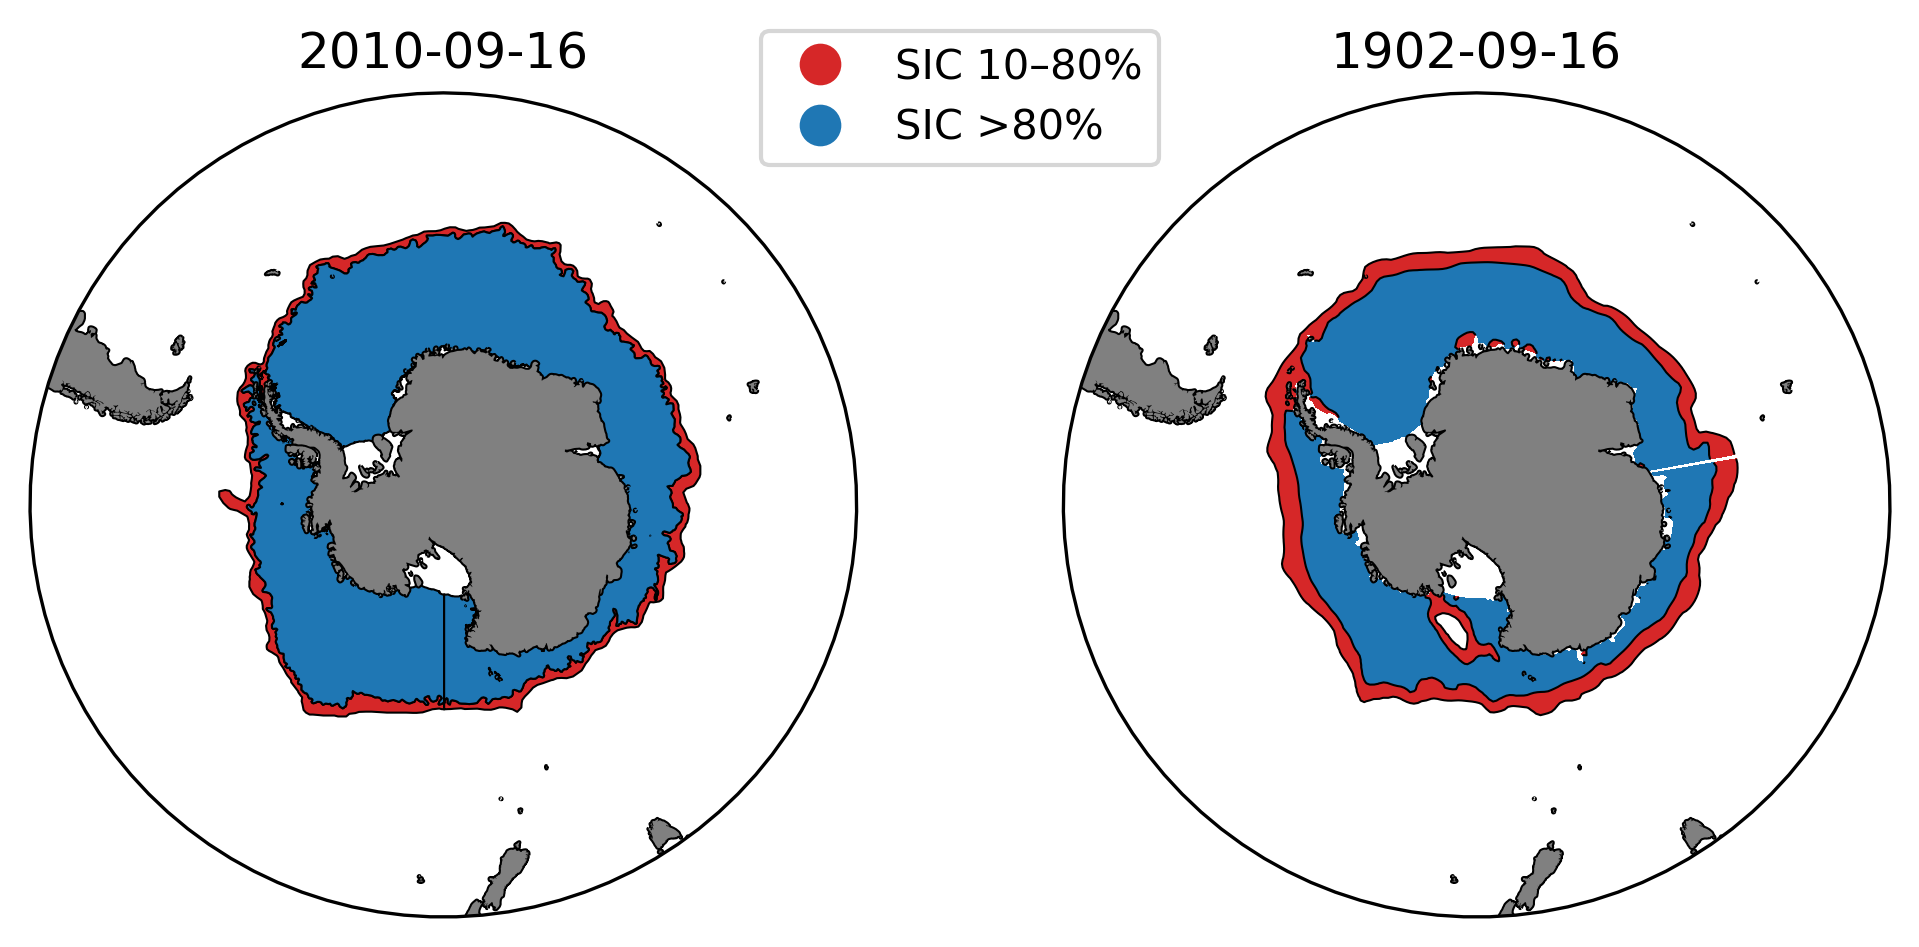

In [10]:
time_idx = -5
hemisphere = "south"

model_dt = ds.time.isel(time=time_idx).values.item()  
year = model_dt.strftime("%Y")   
if int(year) < 2010: year = '2010' # Obs start in 2010
day_of_year = (model_dt - cftime.DatetimeNoLeap(model_dt.year, 1, 1)).days + 1

if hemisphere == "south":
    base_path = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/datasets/USNIC/ice_charts/antarctic/"
    folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
elif hemisphere == "north":
    base_path = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/datasets/USNIC/ice_charts/arctic/"
    folder_name = f"nic_miz{year}{day_of_year:03d}nc_pl_a"
    
get_ice_charts_data(base_path, folder_name, year, hemisphere=hemisphere, print_warn=True)
# Datetimes of NSIDC obs and OM3 model outputs
obs_dt = datetime(int(year), 1, 1) + timedelta(days=day_of_year - 1)

# Load shapefile
shp_file = glob.glob(os.path.join(base_path, year, folder_name, "*.shp"))[0]
gdf = gpd.read_file(shp_file)

# Make plot
fig, axes = plot_maps(ds, gdf, model_dt, obs_dt, hemisphere=hemisphere)


### Climatology

In [11]:
def load_nsidc_climatology(hemisphere):
    # Take the 15th of each month
    days_of_year = np.array([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])
    years = np.arange(2010, 2026)
    
    rows = []   # List of dictionaries for final dataframe
    
    for year in tqdm(years):
        for i, day_of_year in enumerate(days_of_year):
            if hemisphere == "south":
                base_path = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/datasets/USNIC/ice_charts/antarctic/"
                folder_name = f"nic_miz{year}{day_of_year:03d}sc_pl_a"
            elif hemisphere == "north":
                base_path = f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/datasets/USNIC/ice_charts/arctic/"
                folder_name = f"nic_miz{year}{day_of_year:03d}nc_pl_a"
                
            get_ice_charts_data(base_path, folder_name, year, hemisphere=hemisphere)
            shp_file = glob.glob(os.path.join(base_path, str(year), folder_name, "*.shp"))
    
            # Default values
            miz_extent = np.nan
            inner_extent = np.nan
    
            if not shp_file:
                print(f"No shapefile for {folder_name} — skipping.")
            else:
                gdf = gpd.read_file(shp_file[0])
    
                # Find correct area column
                possible_cols = ["SHAPE_Area", "Shape_Area"]
                area_col = next((c for c in possible_cols if c in gdf.columns), None)
    
                if area_col is None:
                    print(f"No area column for {folder_name}. Columns: {list(gdf.columns)}")
                    print(gdf)
                else:
                    areas = gdf.groupby("ICECODE")[area_col].sum()
                    miz_extent = areas.iloc[0]
                    inner_extent = areas.iloc[1]
    
            month = i + 1
            rows.append({
                "year": year,
                "month": month,
                "date": datetime(year, month, 15),
                "miz_extent": miz_extent,
                "inner_extent": inner_extent,
                "sea_ice_extent": miz_extent + inner_extent
            })
    
    df = pd.DataFrame(rows)
    return df

df_arctic = load_nsidc_climatology(hemisphere='north')
df_antarctic = load_nsidc_climatology(hemisphere='south')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010015sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010015sc_pl_a — skipping.
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010046sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010046sc_pl_a — skipping.
URL does not exist (https://noaadata.apps.nsidc.org/NOAA/G10017/south/2010/nic_miz2010074sc_pl_a.zip) — skipping download.
No shapefile for nic_miz2010074sc_pl_a — skipping.
Extracting into /g/data/ps29/nd0349/datasets/USNIC/ice_charts/antarctic/2025/nic_miz2025349sc_pl_a…


### Calculate climatology of observations

In [20]:
df_clim_arctic = df_arctic.groupby('month').mean()
df_clim_arctic

,year,date,miz_extent,inner_extent,sea_ice_extent
month,,,,,
1,2017.5,2017-07-16 06:00:00,7.500792e+11,1.219003e+13,1.294011e+13
2,2017.5,2017-08-16 06:00:00,8.883722e+11,1.306159e+13,1.394996e+13
3,2017.5,2017-09-13 12:00:00,9.632161e+11,1.326971e+13,1.423293e+13
4,2017.5,2017-10-14 12:00:00,1.004791e+12,1.246673e+13,1.347152e+13
5,2017.5,2017-11-13 12:00:00,1.230753e+12,1.100230e+13,1.223305e+13
6,2017.5,2017-12-14 12:00:00,1.816560e+12,9.120971e+12,1.093753e+13
7,2017.5,2018-01-13 12:00:00,2.134781e+12,6.690291e+12,8.825072e+12
8,2017.5,2018-02-13 12:00:00,1.804802e+12,4.349674e+12,6.154477e+12
9,2017.5,2018-03-16 12:00:00,1.144184e+12,3.574455e+12,4.718639e+12


In [21]:
df_clim_antarctic = df_antarctic.groupby('month').mean()
df_clim_antarctic

,year,date,miz_extent,inner_extent,sea_ice_extent
month,,,,,
1,2017.5,2017-07-16 06:00:00,2.843787e+12,4.069199e+12,6.912986e+12
2,2017.5,2017-08-16 06:00:00,1.882043e+12,2.233526e+12,4.115569e+12
3,2017.5,2017-09-13 12:00:00,1.100344e+12,3.370462e+12,4.470807e+12
4,2017.5,2017-10-14 12:00:00,8.275513e+11,5.975079e+12,6.802630e+12
5,2017.5,2017-11-13 12:00:00,9.139147e+11,9.095975e+12,1.000989e+13
6,2017.5,2017-12-14 12:00:00,1.521787e+12,1.204202e+13,1.356381e+13
7,2017.5,2018-01-13 12:00:00,1.672999e+12,1.449856e+13,1.617156e+13
8,2017.5,2018-02-13 12:00:00,1.946506e+12,1.638380e+13,1.833031e+13
9,2017.5,2018-03-16 12:00:00,2.010428e+12,1.736447e+13,1.937490e+13


### Calculate the model's climatology

In [22]:
ds_clim = ds.groupby('time.month').mean('time').compute()
ds_clim

<xarray.Dataset> Size: 60MB
Dimensions:        (month: 12, yh: 300, xh: 360)
Coordinates: (12/13)
    TLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    TLAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ULAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    NLON           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    NLAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
    ...             ...
    ELAT           (yh, xh) float64 864kB nan nan nan nan ... nan nan nan nan
  * xh             (xh) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yh             (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    lon            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
    lat            (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    aice_m         (month, yh, xh) float64 10MB nan nan nan nan ... nan nan nan
    wave_sig_ht_m  (month, yh, xh) float64 10MB nan nan nan nan ... nan nan nan
    fsdrad_m       (month, yh, xh) float64 10MB nan nan nan nan ... nan nan nan
    tarea          (month, yh, xh) float64 10MB nan nan nan nan ... nan nan nan
    HTE            (month, yh, xh) float64 10MB nan nan nan nan ... nan nan nan
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

## Compare MCW with NSIDC using the sea ice concentration definition

In [23]:
def _get_var(ds, names):
    """Return the first matching variable name in ds."""
    for n in names:
        if n in ds:
            return n
    raise KeyError(f"None of the variables {names} found in dataset.")



def _get_mask(ds, definition, hemisphere, threshold=None):
    # Set defaults for each definition
    defaults = {'wave_sig_ht': 0.05, 'aice': 0.8, 'fsdrad': 200}
    if threshold is None:
        try:
            threshold = defaults[definition]
        except KeyError:
            raise ValueError(f"Unknown definition: {definition}")

    # Example for aice
    aice_var = _get_var(ds, ['aice_m', 'aice'])
    wave_var = _get_var(ds, ['wave_sig_ht_m', 'wave_sig_ht'])
    fsd_var = _get_var(ds, ['fsdrad_m', 'fsdrad'])
    
    # Hemisphere mask
    if hemisphere == 'south':
        hemi_mask = ds['TLAT'] < 0
    elif hemisphere == 'north':
        hemi_mask = ds['TLAT'] > 0
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")

    # Base ice presence mask
    base_mask = ds[aice_var] > 0.10

    # Definition-specific condition
    if definition == 'wave_sig_ht':
        cond = ds[wave_var] > threshold
    elif definition == 'aice':
        cond = ds[aice_var] < threshold
    elif definition == 'fsdrad':
        cond = ds[fsd_var] < threshold
    elif definition in ['SIE', 'SIA']:
        cond = base_mask
    else:
        raise ValueError(f"Unknown definition: {definition}")

    return base_mask & cond & hemi_mask



def _integrate_area(ds, mask, definition):
    if definition == "SIA":
        return ds['tarea']*ds['aice_m'].where(mask).sum(dim=['xh', 'yh'])
    else:
        return ds['tarea'].where(mask).sum(dim=['xh', 'yh'])



def calculate_area(ds_cice, definition='wave', threshold=0.05, integration='simple', 
                        measure='median', mask=True, method='naive', hemisphere='south'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    sea_ice_extent = _integrate_area(ds_cice, mask_2d, definition) * 1e-12

    if definition in ["wave_sig_ht", "aice", "fsdrad"]:
        name = "MIZ area"
    elif definition == "SIE":
        name = "Sea ice extent"
    elif definition == "SIA":
        name = "Sea ice area"

    return xr.DataArray(
        sea_ice_extent,
        dims=sea_ice_extent.dims,
        coords={'month': ds_cice['month']},
        name=name,
        attrs={
            'units': '10^6 km^2',
            'description': f'MIZ extent ({definition})'
        }
    )

In [24]:
# Calculate Arctic extents
hemisphere = "south"
antarctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
antarctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
antarctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [25]:
# Calculate Arctic extents
hemisphere = "north"
arctic_sie = calculate_area(ds_clim, definition='SIE', hemisphere=hemisphere)
arctic_sia = calculate_area(ds_clim, definition='SIA', hemisphere=hemisphere)
arctic_miz_extent_wave = calculate_area(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_extent_aice = calculate_area(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_extent_fsdrad = calculate_area(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

### Plot the comparison with NSIDC

In [26]:
def figure(region=None):
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.12)

    axes[0].text(0.0, 1.03, 'a) ANTARCTIC', fontsize=12, fontweight='bold', transform=axes[0].transAxes)
    axes[1].text(0.0, 1.03, 'b) ARCTIC', fontsize=12, fontweight='bold', transform=axes[1].transAxes)
    
    for i, ax in enumerate(axes):
        ax.plot(np.arange(1,13,1), np.full(12,0), lw=0.5, c='k')
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xlabel('Month')
        
    return fig, axes

Text(0, 0.5, 'Sea Ice Extent [10$^6$ km$^2$]')

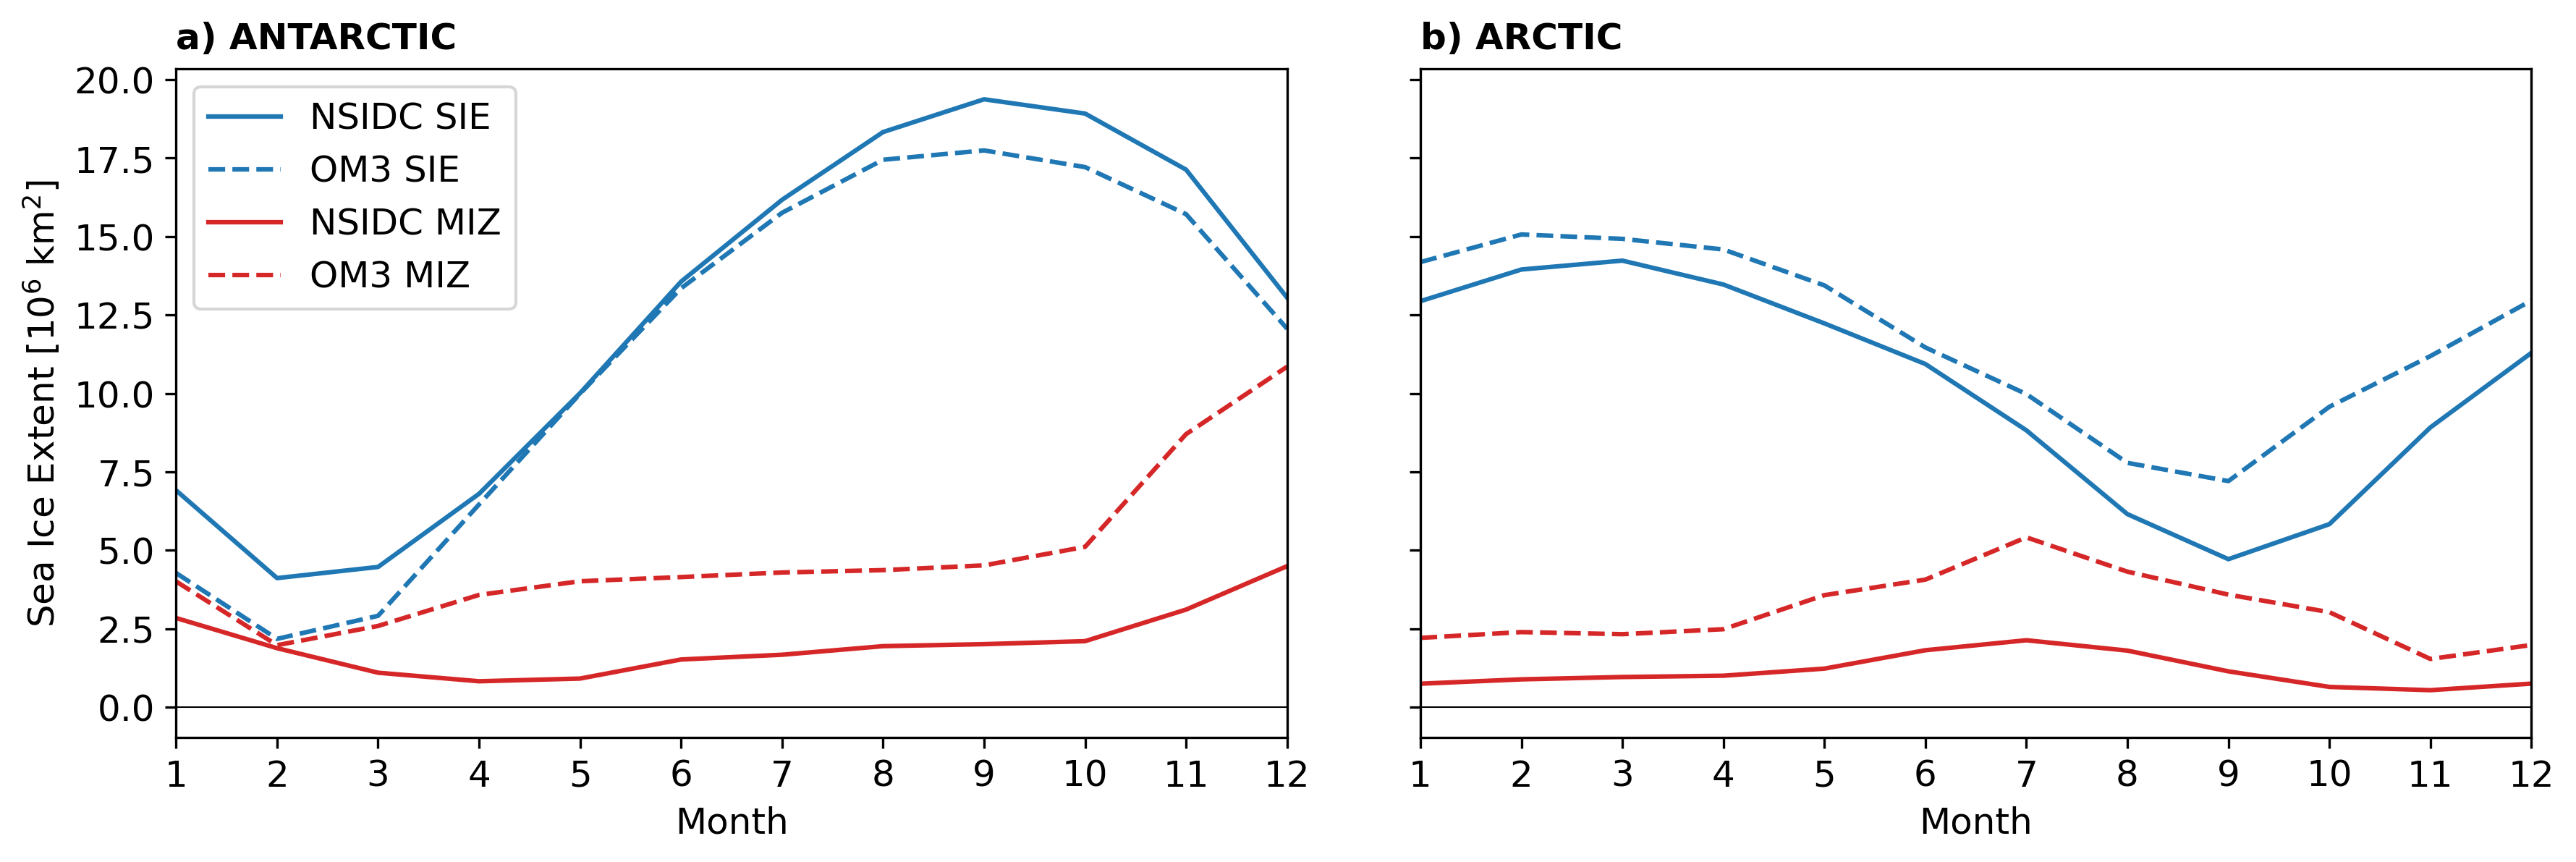

In [27]:
fig, axes = figure()

### ----- ANTARCTIC -----
# df_clim_antarctic
axes[0].plot(df_clim_antarctic.index, df_clim_antarctic['sea_ice_extent'] * 1e-12,
        color=color_sie,
        linestyle='-',
        label="NSIDC SIE",
)
axes[0].plot(antarctic_sie.month, antarctic_sie,
        color=color_sie,
        linestyle='--',
        label="OM3 SIE",
)


# MIZ 
axes[0].plot(df_clim_antarctic.index, df_clim_antarctic['miz_extent'] * 1e-12,
        color=color_miz,
        linestyle='-',
        label="NSIDC MIZ",
)
axes[0].plot(antarctic_miz_extent_aice.month, antarctic_miz_extent_aice,
        color=color_miz,
        linestyle='--',
        label="OM3 MIZ",
)



### ----- ARCTIC -----
# SIE
axes[1].plot(df_clim_arctic.index, df_clim_arctic['sea_ice_extent'] * 1e-12,
        color=color_sie,
        linestyle='-',
        label="NSIDC SIE",
)
axes[1].plot(arctic_sie.month, arctic_sie,
        color=color_sie,
        linestyle='--',
        label="OM3 SIE",
)


# MIZ 
axes[1].plot(df_clim_arctic.index, df_clim_arctic['miz_extent'] * 1e-12,
        color=color_miz,
        linestyle='-',
        label="NSIDC MIZ",
)
axes[1].plot(arctic_miz_extent_aice.month, arctic_miz_extent_aice,
        color=color_miz,
        linestyle='--',
        label="OM3 MIZ",
)

axes[0].legend()
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Sea Ice Extent [10$^6$ km$^2$]")

## Compare different MIZ width defintions

### Calculate MIZ widths

In [28]:
def _integrate_width(width, ds, method):
    if method == 'simple':
        return width.sum(dim='yh', skipna=True)
    elif method == 'weighted':
        aice_var = _get_var(ds, ['aice_m', 'aice'])
        return (width * ds[aice_var]).sum(dim='yh', skipna=True)
    else:
        raise ValueError(f"Unknown integration: {method}")

def _reduce_width(width, method, mask):
    if mask:
        width = width.where(width != 0)
    if method == 'median':
        return width.median(dim='xh', skipna=True)
    elif method == 'mean':
        return width.mean(dim='xh', skipna=True)
    else:
        raise ValueError(f"Unknown measure: {method}")

def calculate_miz_width(ds_cice, definition='wave', threshold=0.3, integration='simple', 
                        measure='median', mask=True, hemisphere='south', freq='monthly'):
    mask_2d = _get_mask(ds_cice, definition, hemisphere, threshold)
    
    miz_width_2d = ds_cice['HTE'].where(mask_2d) / 1000 # m to km
    miz_width_1d = _integrate_width(miz_width_2d, ds_cice, integration)
    miz_width_reduced = _reduce_width(miz_width_1d, measure, mask)

    if freq == 'monthly':
        coords = {'month': ds_cice['month']}
    elif freq == 'dayofyear':
        coords = {'dayofyear': ds_cice['dayofyear']}

    return xr.DataArray(
        miz_width_reduced,
        dims=miz_width_reduced.dims,
        coords=coords,
        name='miz_width',
        attrs={
            'units': 'km',
            'description': f'MIZ width ({definition})'
        }
    )

In [29]:
hemisphere='south'
antarctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
antarctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
antarctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

In [30]:
hemisphere='north'
arctic_miz_width_wave = calculate_miz_width(ds_clim, definition='wave_sig_ht', hemisphere=hemisphere)
arctic_miz_width_aice = calculate_miz_width(ds_clim, definition='aice', threshold=0.8, hemisphere=hemisphere)
arctic_miz_width_fsdrad = calculate_miz_width(ds_clim, definition='fsdrad', threshold=200, hemisphere=hemisphere)

### Plot MIZ widths

Text(0, 0.5, 'MIZ width [km]')

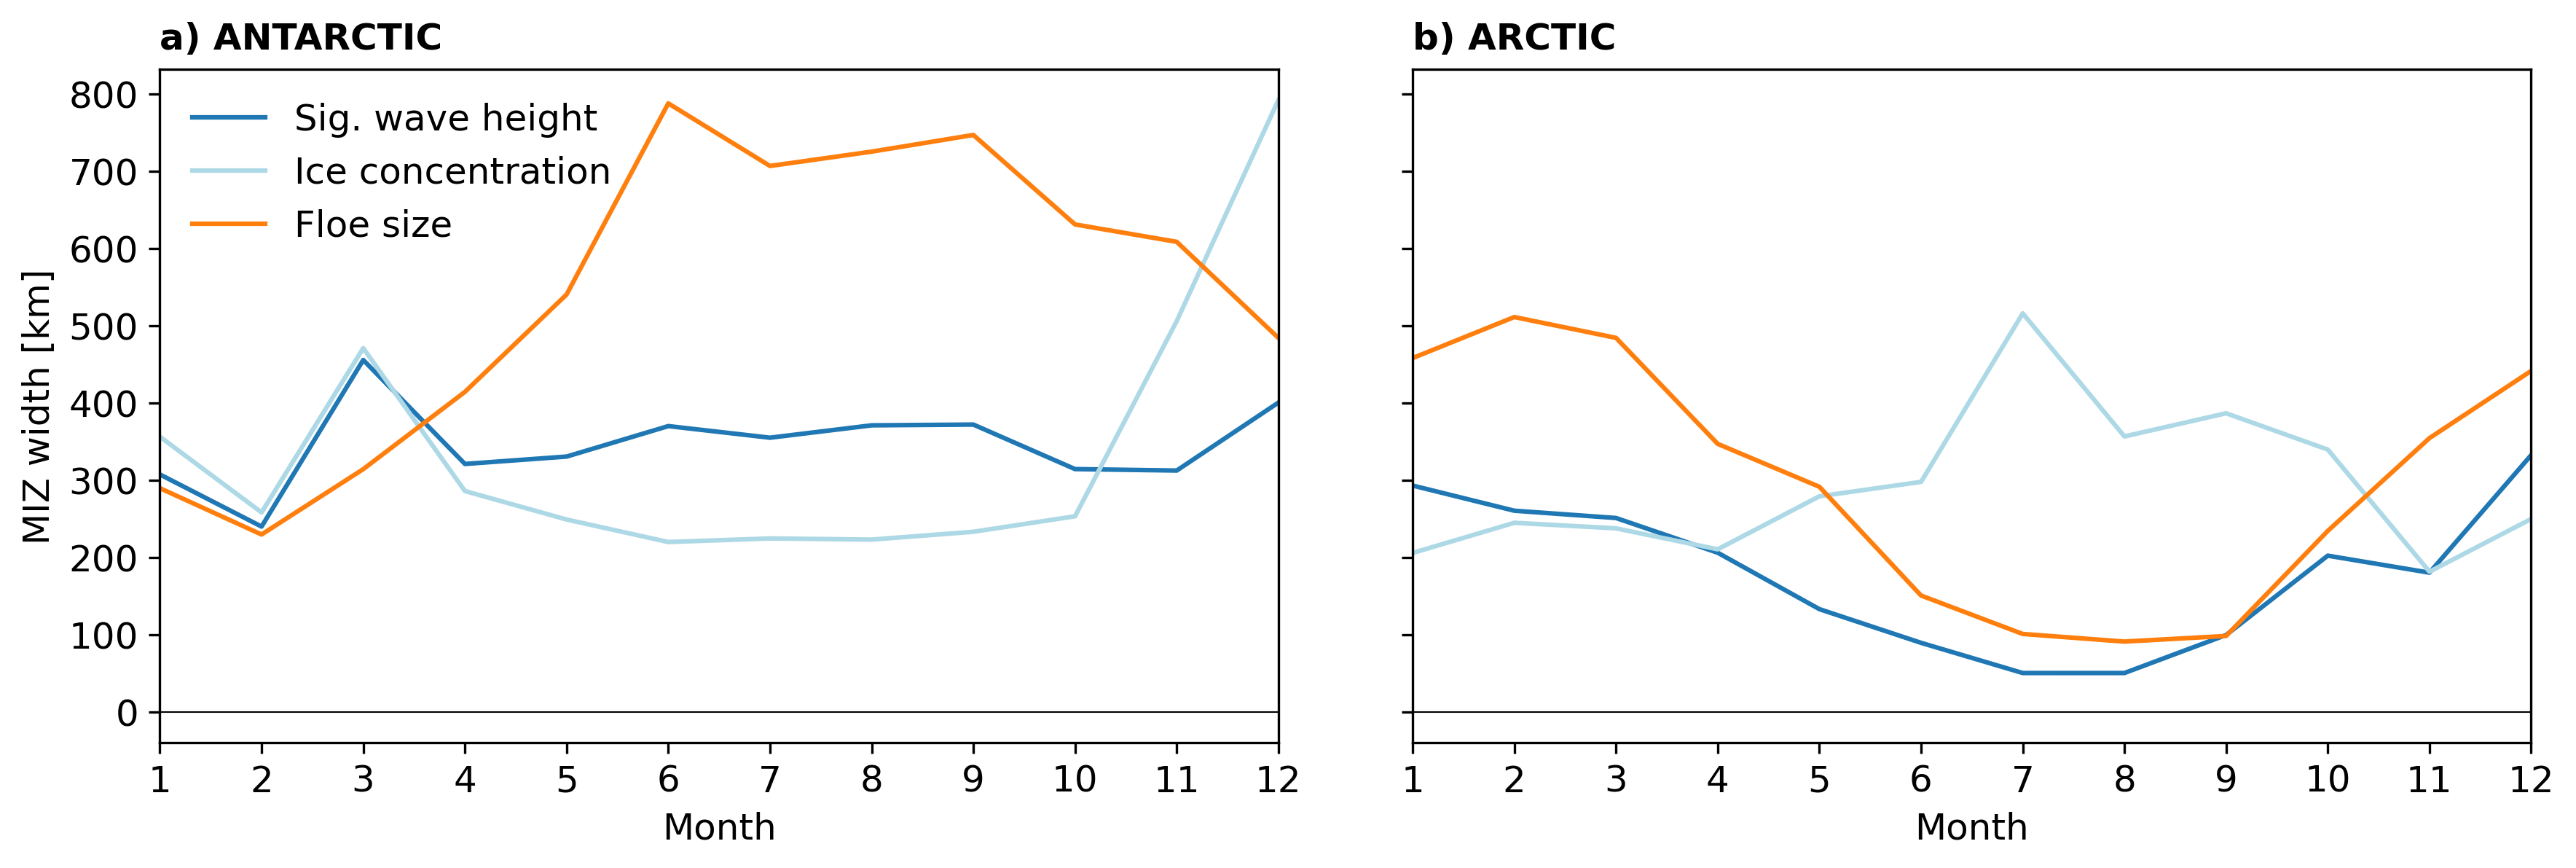

In [31]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_width_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_width_fsdrad, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_width_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_width_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_width_fsdrad, label='Floe size')

axes[0].set_ylabel("MIZ width [km]")

### Plot MIZ areas

Text(0, 0.5, 'Sea Ice Area [$10^6$ km$^2$]')

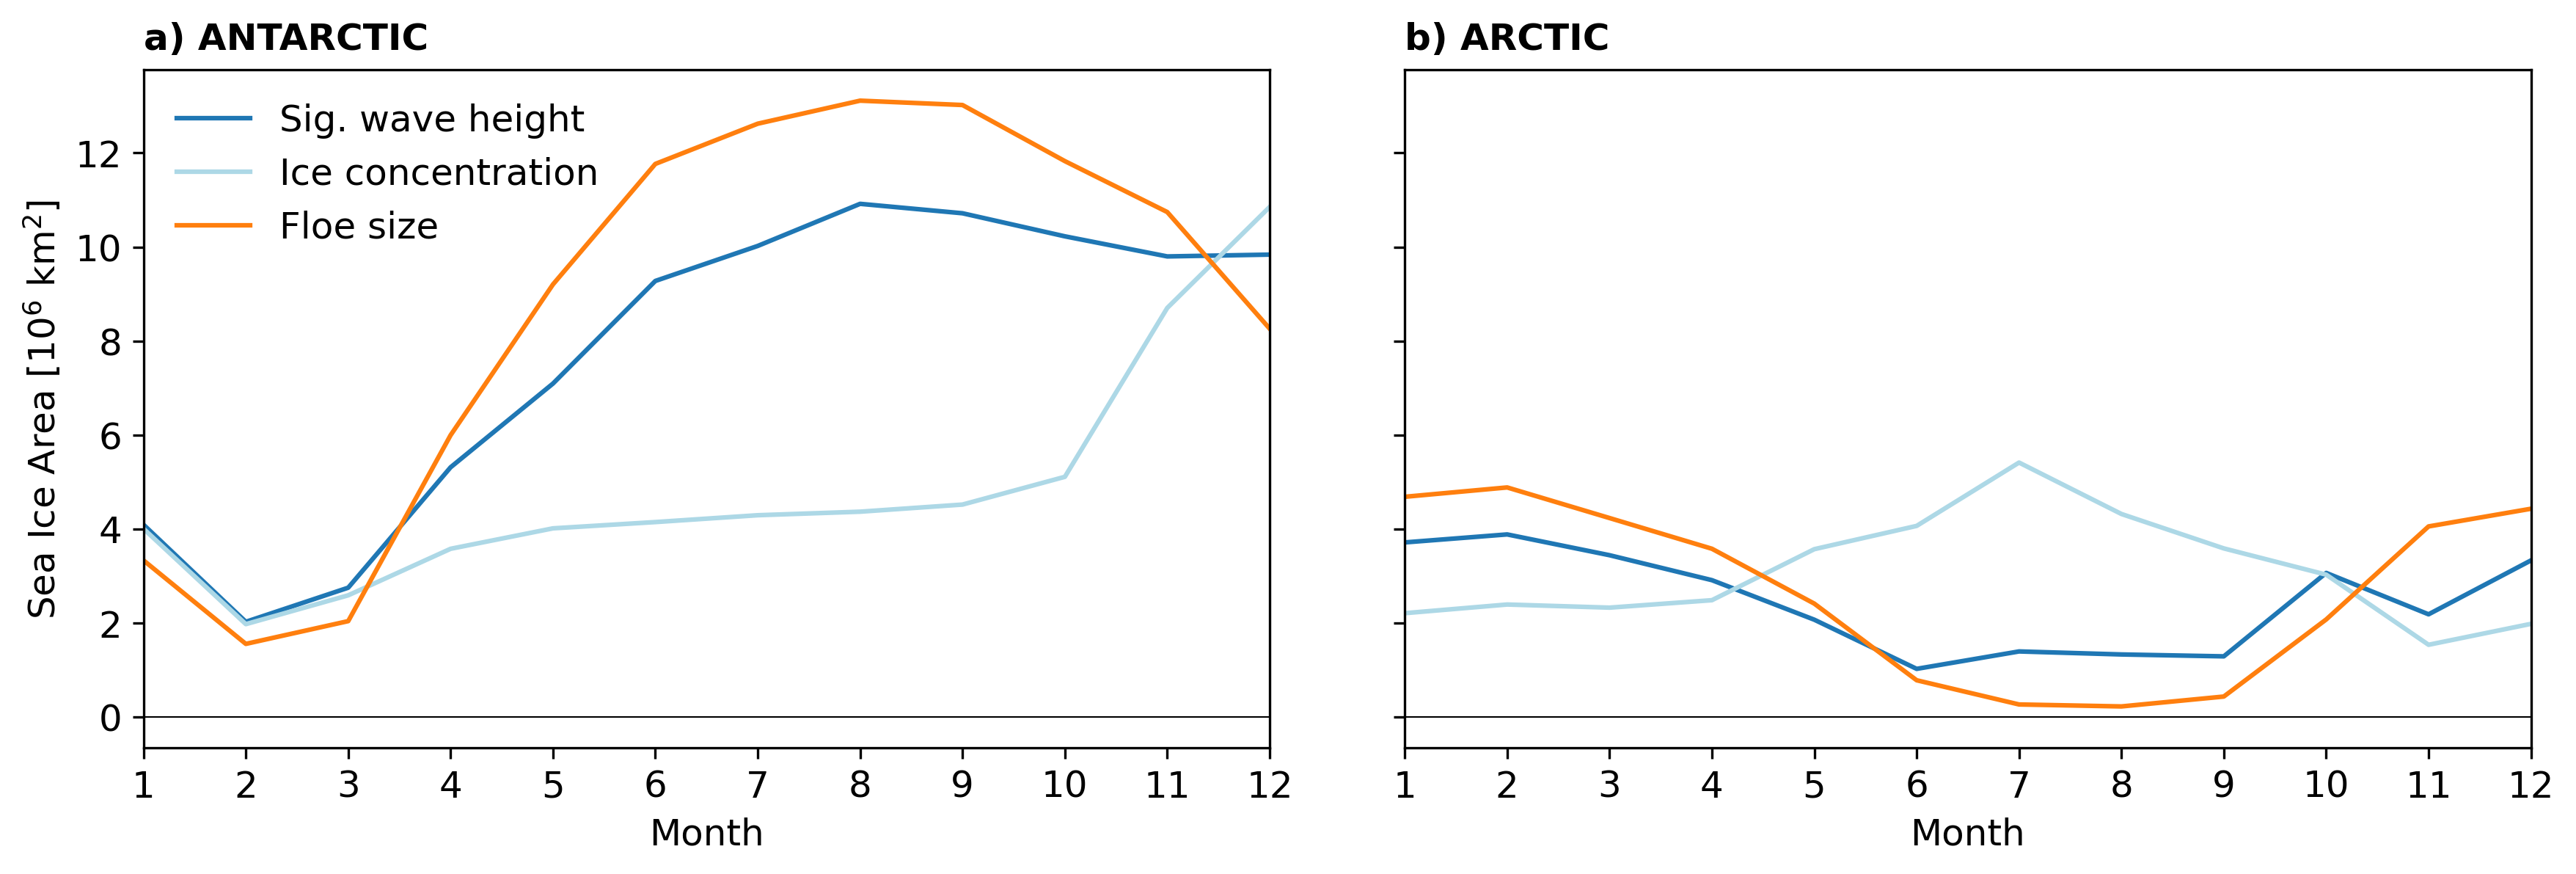

In [32]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12)

axes[1].plot(x, arctic_miz_extent_wave, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad, label='Floe size')

axes[0].set_ylabel("Sea Ice Area [$10^6$ km$^2$]")

### Plot MIZ fraction

Text(0, 0.5, 'Marginal Ice Zone Fraction')

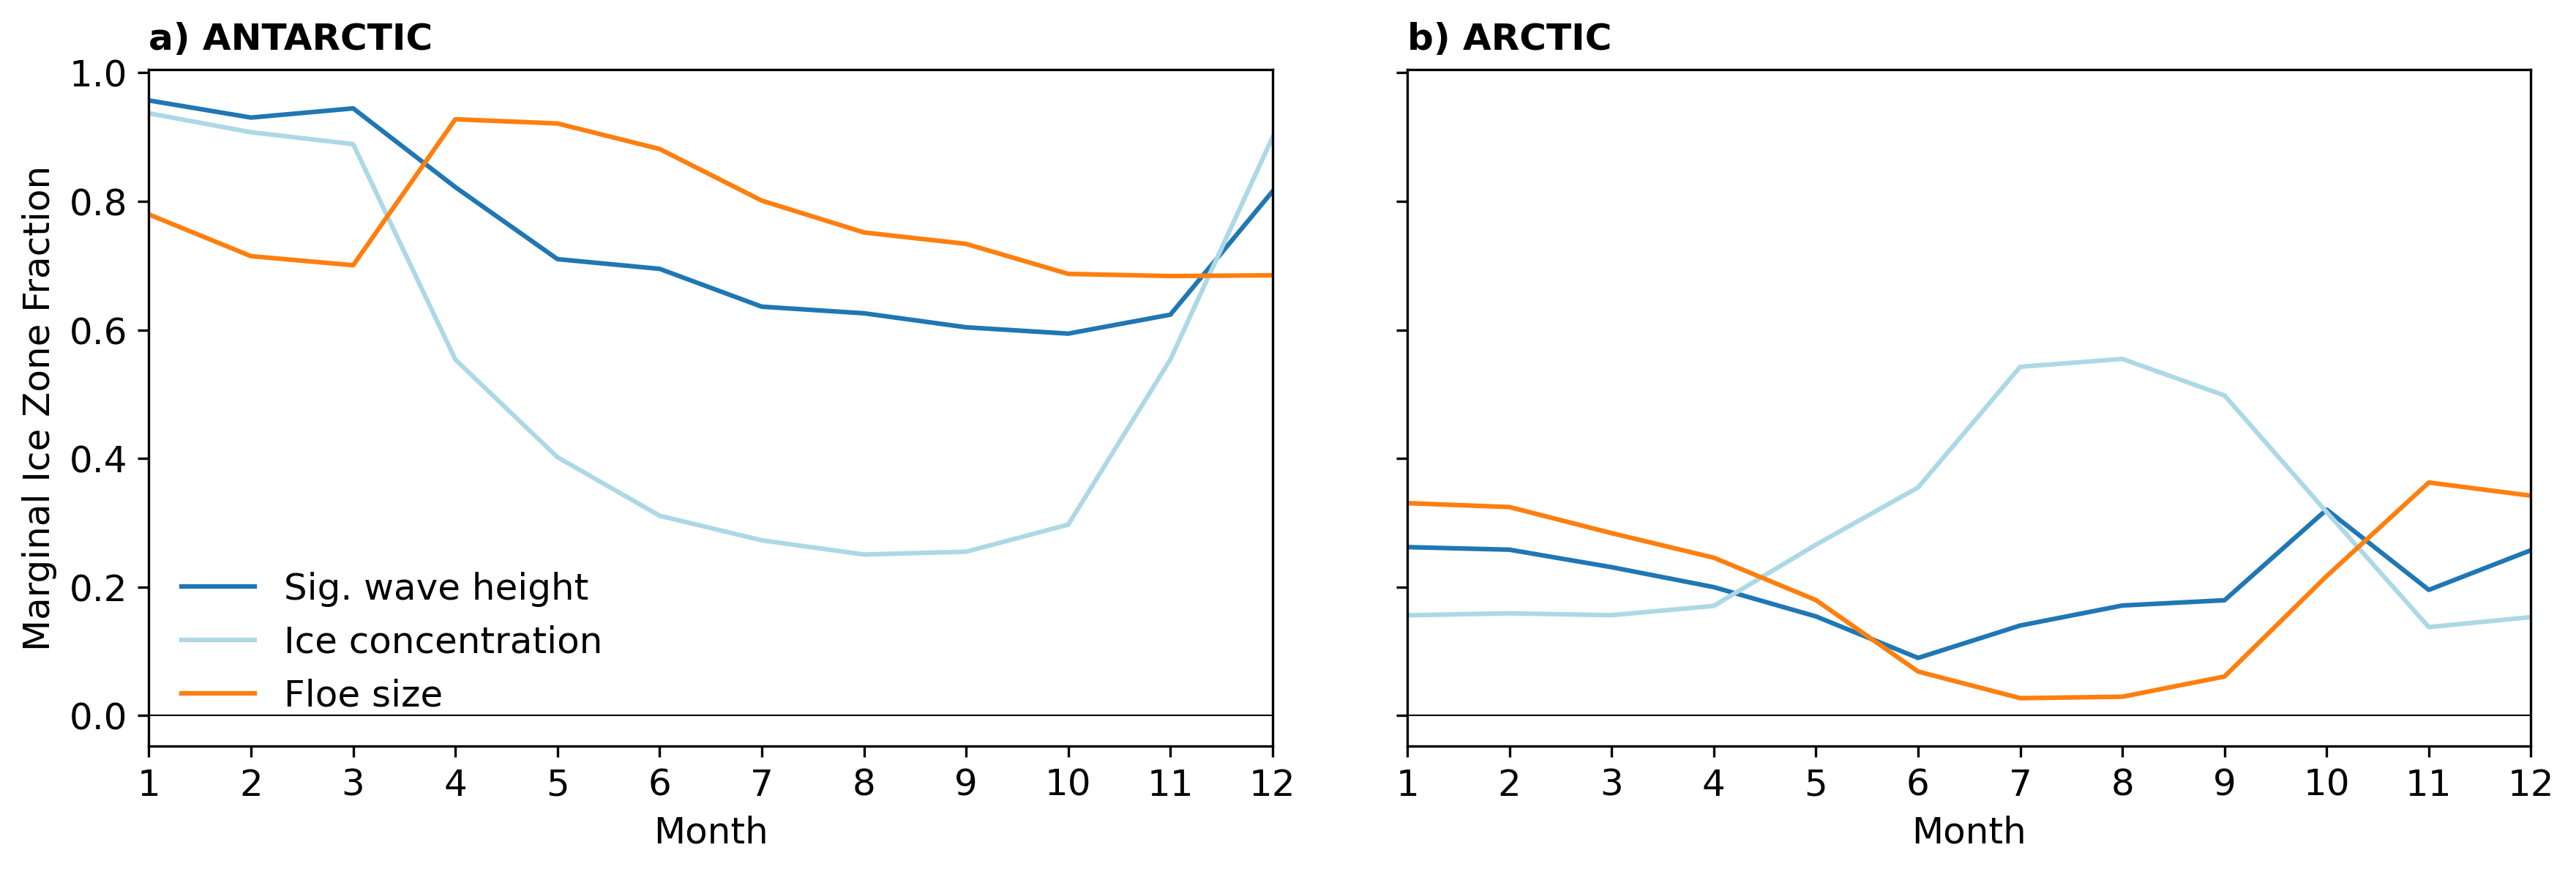

In [34]:
fig, axes = figure()

x = np.arange(1, 13)
axes[0].plot(x, antarctic_miz_extent_wave/antarctic_sie, label='Sig. wave height')
axes[0].plot(x, antarctic_miz_extent_aice/antarctic_sie, label='Ice concentration', color='lightblue')
axes[0].plot(x, antarctic_miz_extent_fsdrad/antarctic_sie, label='Floe size')

axes[0].legend(frameon=False, ncols=1, fontsize=12, loc="lower left")

axes[1].plot(x, arctic_miz_extent_wave/arctic_sie, label='Sig. wave height')
axes[1].plot(x, arctic_miz_extent_aice/arctic_sie, label='Ice concentration', color='lightblue')
axes[1].plot(x, arctic_miz_extent_fsdrad/arctic_sie, label='Floe size')

axes[0].set_ylabel("Marginal Ice Zone Fraction")

## Calculate apparent attenuation
The apparent attenuation rate is typically calculated in field observations where data on wave directionality and ice conditions is rarely known. As such, it is common to assume that the wave direction is inline with the buoy configuration. Hence, from model output of the frequency spectrum, $S(x, f)$, we can calculate the apparent attenuation via regression
$$
    \frac{1}{a_{\text{ice}}} \log \left( \frac{S_{\text{ice}} (x; f)}{S_0} \right) \sim -\alpha_a  x
$$ which returns the *apparent attenuation*, $\alpha_a$, over distance, $x$ for ice concentration $a_{\text{ice}}$.

### First we need to load WW3 data

In [50]:

datastore_filtered = datastore.search(realm="wave")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
EF,1D spectral density,,,m2 s
FP0,Peak frequency,,,s-1
HS,Significant wave height,,,m
ICE,Ice coverage,,,nd
ICEF,Ice floe diameter,,,m
ICEH,Ice thickness,,,m
T01,"Mean wave period (Tm0,1)",,,s
T02,"Mean wave period (Tm0,2)",,,s
T0M1,"Mean wave period (Tm0,-1)",,,s


In [49]:

# datastore_filtered = datastore.search(realm="seaIce")

# available_variables(datastore_filtered)

In [67]:
def load_coords(datastore):
    coords = (
        datastore.search(variable=["TLAT", "TLON", "tarea", "HTE", "HTN"])
        .to_dask()
        .compute()
        .fillna(0.0)
        .rename({'TLAT': 'lat', 'TLON': 'lon'})
    )
    return coords
    
wave_vars = ["EF", "FP0", "HS", "ICE", "ICEF", "ICEH"]
ds_ww3 = datastore_filtered.search(variable=wave_vars, frequency='fx').to_dask(
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
)

# Attach coordinates
coords = load_coords(datastore)
ds_ww3 = ds_ww3.assign_coords(coords)
ds_ww3 = ds_ww3.rename({'ni':'nx', 'nj':'ny'})
ds_ww3

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 15GB
Dimensions:  (time: 1126, ny: 300, nx: 360, freq: 25)
Coordinates:
  * time     (time) object 9kB 1900-01-02 00:00:00 ... 1906-02-01 00:00:00
    lat      (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    lon      (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    tarea    (ny, nx) float64 864kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HTE      (ny, nx) float64 864kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HTN      (ny, nx) float64 864kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: ny, nx, freq
Data variables:
    HS       (time, ny, nx) float32 486MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 486MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 486MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 12GB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 486MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 486MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'EF', 'FP...
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

In [68]:
def get_ww3_freqs(nk=25):
    """
    Generate WW3 frequency bins and corresponding periods.
    
    Parameters
    ----------
    nk : float
        Number of wave numbers/frequency bins.
    """
    f1 = 0.04118   # lowest frequency [Hz]
    xfr = 1.1      # frequency growth factor
    
    freqs = f1 * xfr**np.arange(nk)
    periods = 1.0 / freqs
    return freqs, periods

# -----------------------------------------------------------------------------
def mbk_2014_attenuation(periods=None):
    """
    Calculate wave attenuation coefficients following Meylan, Bennetts, and Kohout (2014)
    as a function of wave period.
    
    Parameters
    ----------
    periods : array-like, optional
        Wave periods [s]. If None, uses WW3 default frequency bins.
    
    Returns
    -------
    α : np.ndarray
        Attenuation coefficients [1/m] for each period.
    """
    if periods is None:
        _, periods = get_ww3_freqs()
    
    a = 2.2e-3
    b = 4.59e-2
    α = a / periods**2 + b / periods**4
    return α

# -----------------------------------------------------------------------------
def meylan_2021_attenuation(periods, thickness, floeDiameter):
    # Fortran code from WW3 https://github.com/ACCESS-NRI/WW3/blob/dev/2025.08/model/src/w3sic4md.F90
    ICECOEF1 = thickness
    ICECOEF5 = floeDiameter
    x3 = np.minimum(ICECOEF1, 3.5)
    x3 = np.maximum(x3, 0.1)
    x2 = np.minimum(ICECOEF5*0.5, 100.0)  # convert dia to radius, limit to 100m
    x2 = np.maximum(2.5, x2)
    x2sqr = x2 * x2
    x3sqr = x3 * x3
    amhb = 2.12e-3
    bmhb = 4.59e-2

    nk = len(periods)
    KARG1 = np.zeros(nk)
    ALPHA = np.zeros(nk)
    WN_I = np.zeros(nk)
    
    for ik in range(nk):
        x1 = periods[ik]
        x1sqr = x1 * x1
        KARG1[ik] = (
            -0.26982
            + 1.5043 * x3
            - 0.70112 * x3sqr
            + 0.011037 * x2
            - 0.0073178 * x2 * x3
            + 0.00036604 * x2 * x3sqr
            - 0.00045789 * x2sqr
            + 1.8034e-05 * x2sqr * x3
            - 0.7246 * x1
            + 0.12068 * x1 * x3
            - 0.0051311 * x1 * x3sqr
            + 0.0059241 * x1 * x2
            + 0.00010771 * x1 * x2 * x3
            - 1.0171e-05 * x1 * x2sqr
            + 0.0035412 * x1sqr
            - 0.0031893 * x1sqr * x3
            - 0.00010791 * x1sqr * x2
            + 0.00031073 * x1**3
            + 1.5996e-06 * x2**3
            + 0.090994 * x3**3
        )
        
        KARG1[ik] = np.minimum(KARG1[ik], 0.0)
        ALPHA[ik] = 10.0**KARG1[ik]
        perfour = x1sqr * x1sqr
        if 5.0 < x1 < 20.0:
            ALPHA[ik] += amhb / x1sqr + bmhb / perfour
        elif x1 > 20.0:
            ALPHA[ik] = amhb / x1sqr + bmhb / perfour
        
        WN_I[ik] = ALPHA[ik] * 0.5

    α = ALPHA
    k_imaginary = WN_I
    return α, k_imaginary


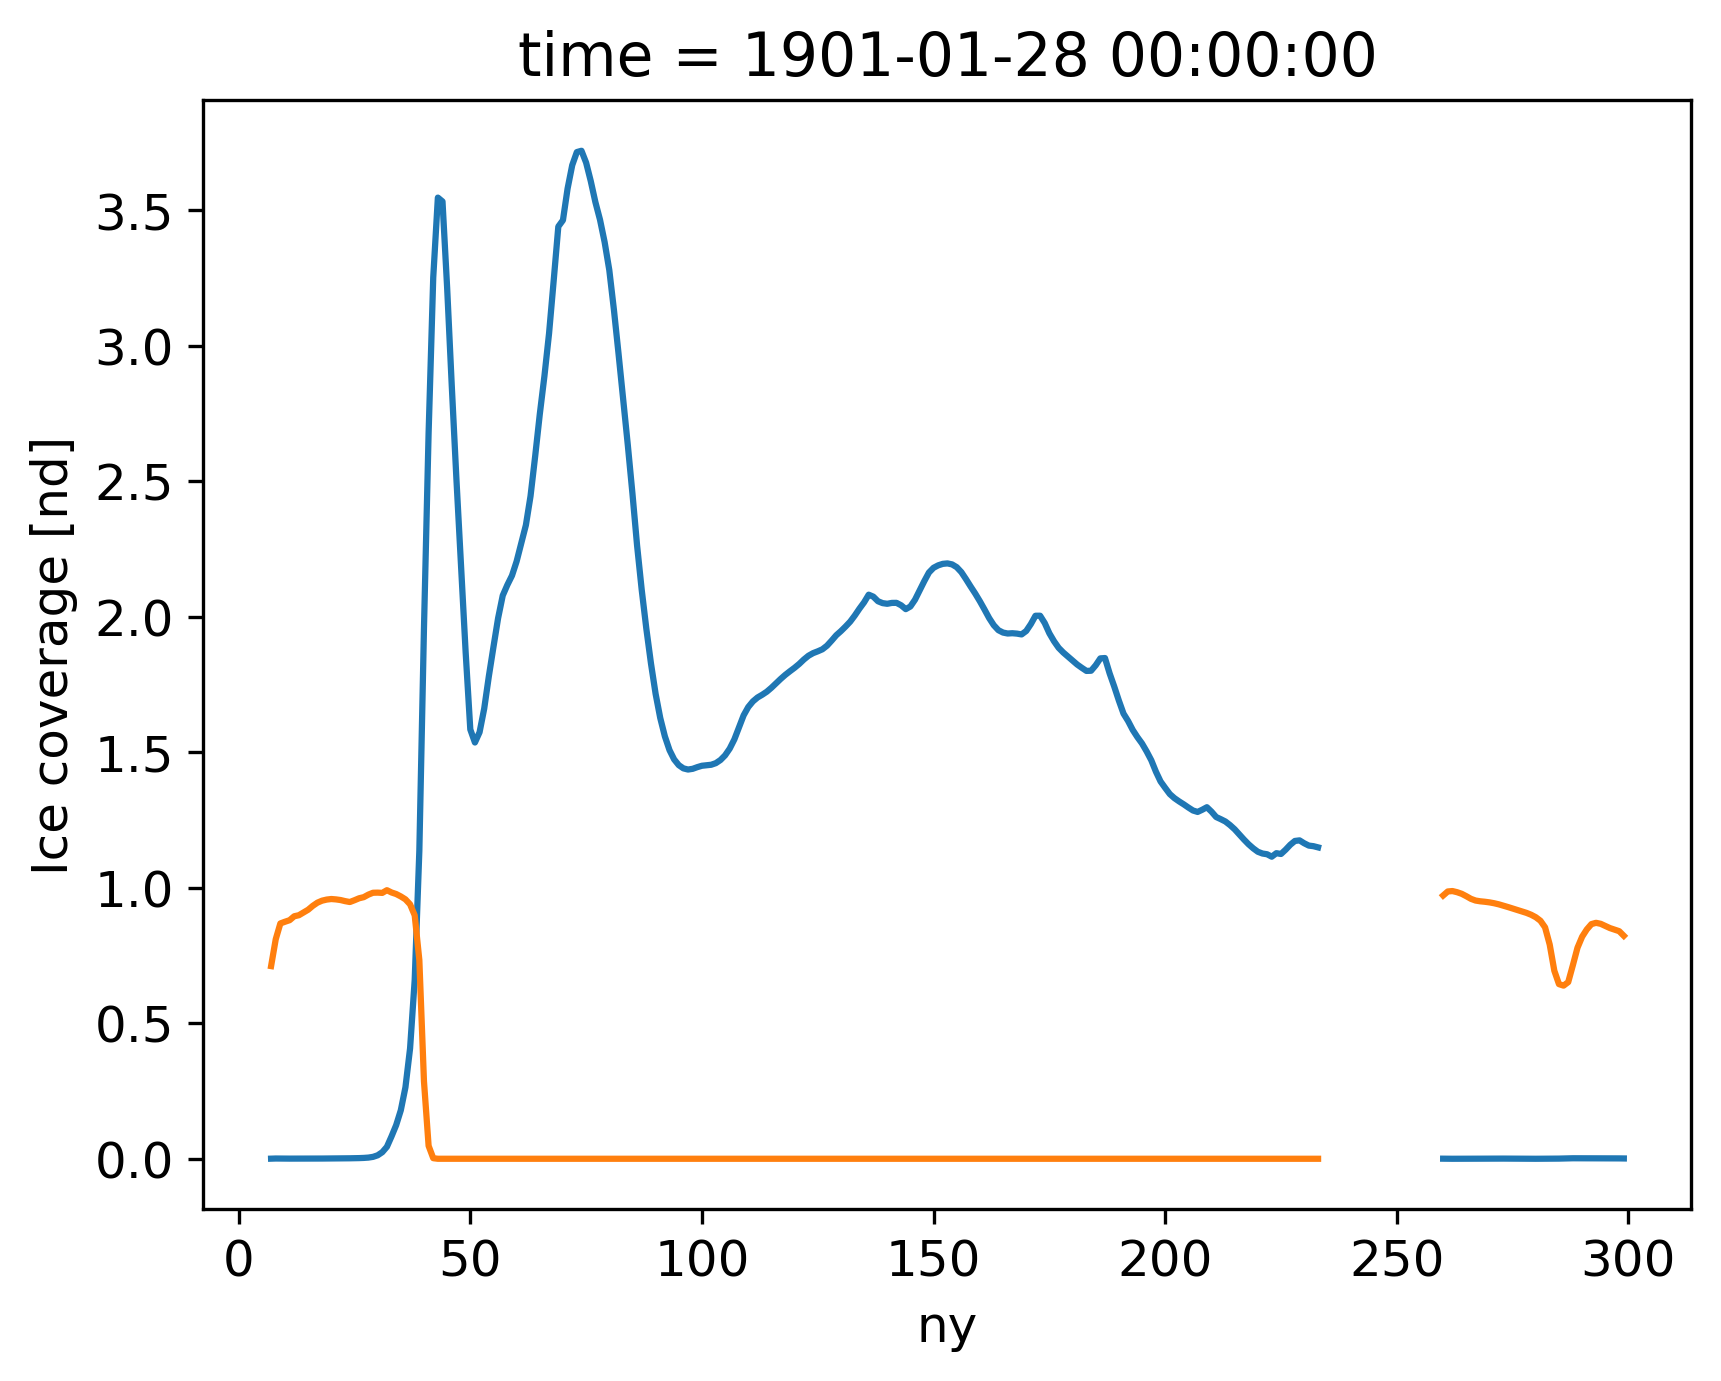

In [80]:
time_idx = 210
nx_idx = 130
ds_ww3.isel(time=time_idx, nx=nx_idx)['HS'].plot()
ds_ww3.isel(time=time_idx, nx=nx_idx)['ICE'].plot()

In [149]:
mask = ((ds_ww3['lat'] < 0) & (ds_ww3['ICE'] > 1e-11) & (ds_ww3['HS'] > 1e-11)).compute()
ds_transect = ds_ww3.where(mask, drop=True).isel(time=time_idx, nx=nx_idx)
ds_transect

<xarray.Dataset> Size: 10kB
Dimensions:  (ny: 50, freq: 25)
Coordinates:
    time     object 8B 1901-01-28 00:00:00
    lat      (ny) float64 400B -77.63 -77.38 -77.13 ... -56.24 -55.46 -54.67
    lon      (ny) float64 400B 210.5 210.5 210.5 210.5 ... 210.5 210.5 210.5
    ULON     (ny) float64 400B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ULAT     (ny) float64 400B -77.51 -77.26 -77.01 ... -55.85 -55.07 -54.26
    NLON     (ny) float64 400B -149.5 -149.5 -149.5 ... -149.5 -149.5 -149.5
    NLAT     (ny) float64 400B -77.51 -77.26 -77.01 ... -55.85 -55.07 -54.26
    ELON     (ny) float64 400B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ELAT     (ny) float64 400B -77.63 -77.38 -77.13 ... -56.24 -55.46 -54.67
    tarea    (ny) float64 400B 6.555e+08 6.718e+08 ... 5.516e+09 5.724e+09
    HTE      (ny) float64 400B 2.752e+04 2.766e+04 ... 8.749e+04 8.901e+04
    HTN      (ny) float64 400B 2.406e+04 2.453e+04 ... 6.368e+04 6.494e+04
Dimensions without coordinates: ny, freq
Data variables:
    HS       (ny) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    ICE      (ny) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    ICEF     (ny) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    EF       (freq, ny) float32 5kB dask.array<chunksize=(25, 50), meta=np.ndarray>
    FP0      (ny) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    ICEH     (ny) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'EF', 'FP...
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 21.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


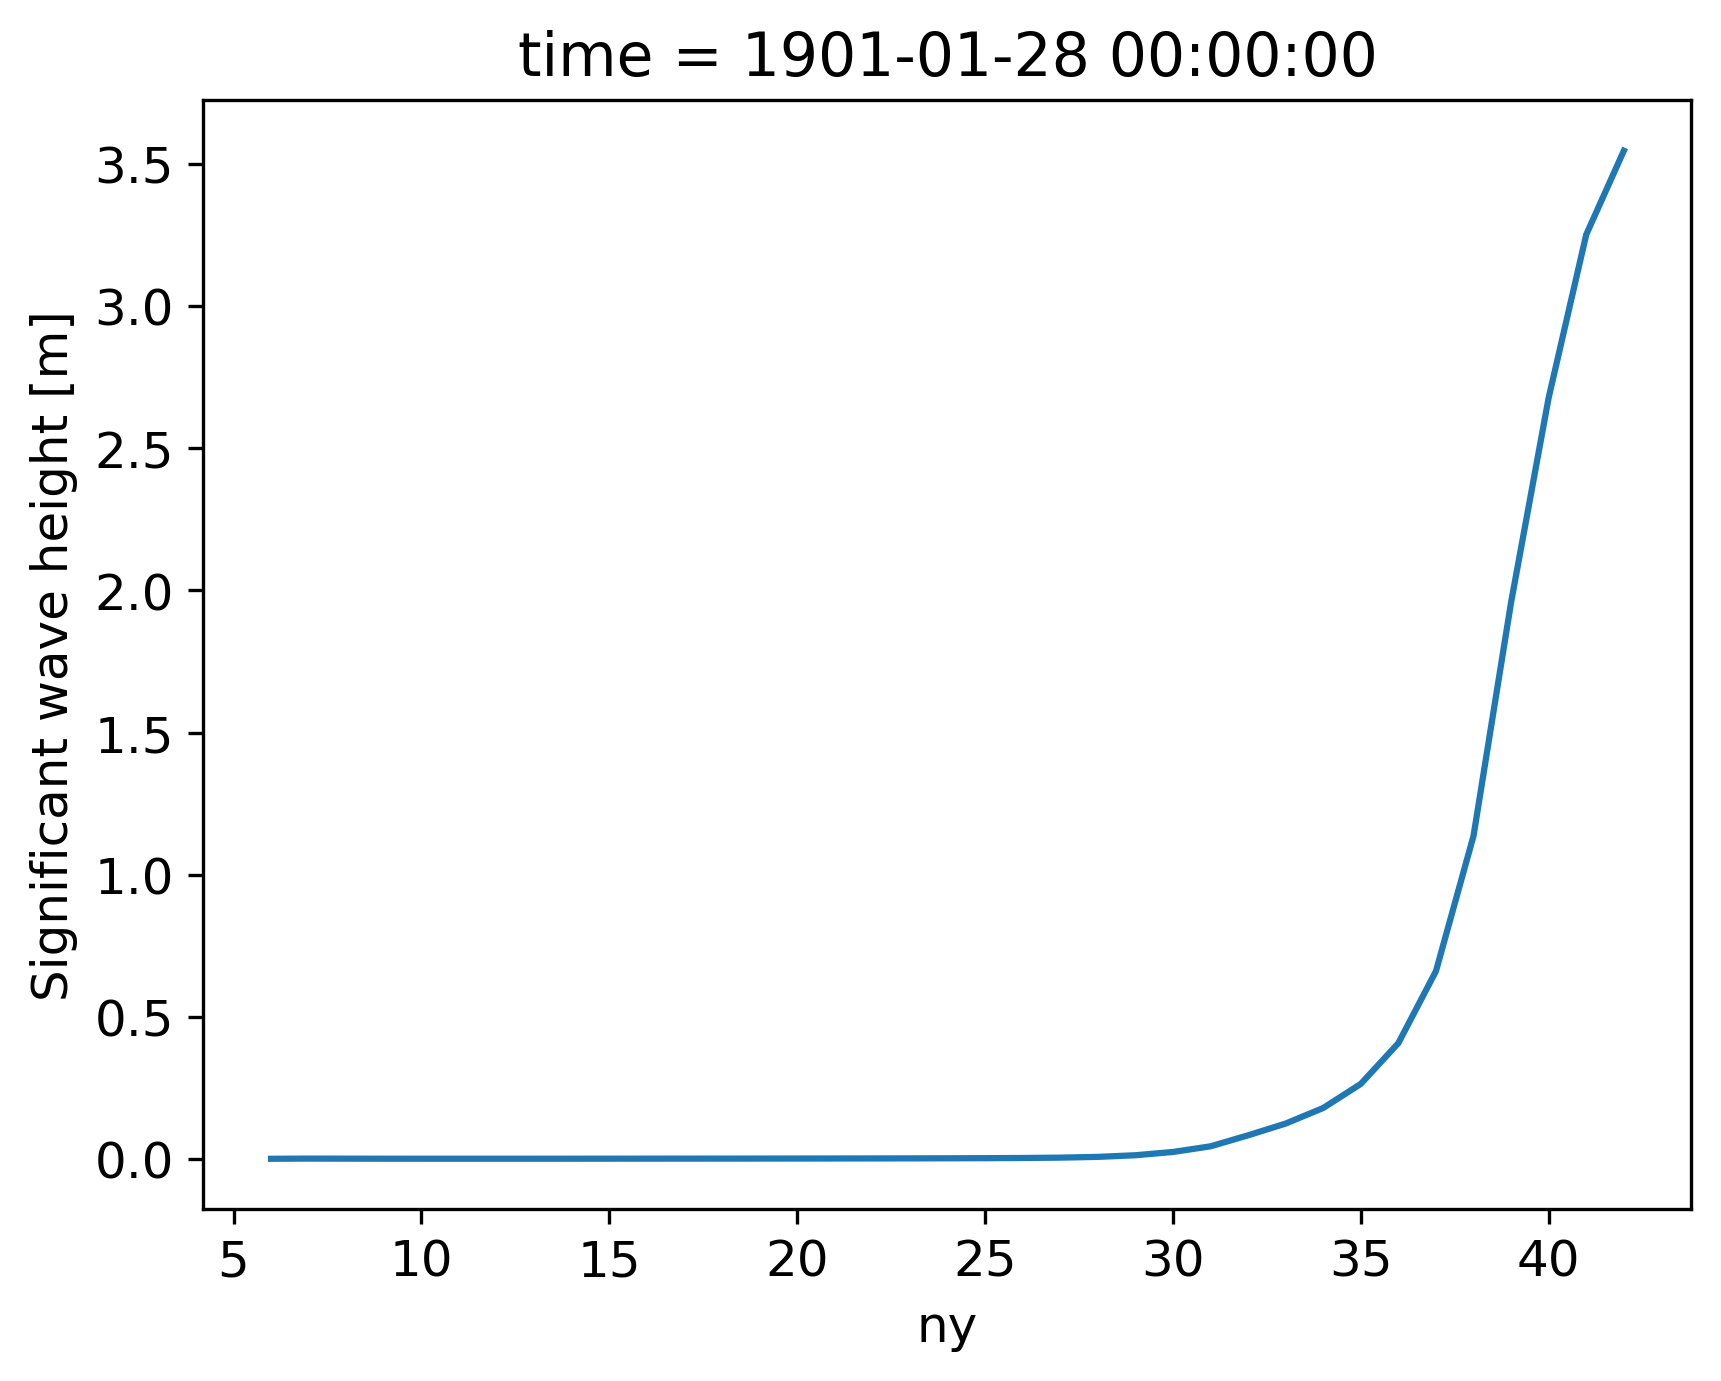

In [150]:
ds_transect['HS'].plot()

In [156]:
mask = ~ np.isnan(ds_transect['HS']).compute()
ds_transect = ds_transect.where(mask, drop=True)
ds_transect

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 21.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 8kB
Dimensions:  (ny: 37, freq: 25)
Coordinates:
    time     object 8B 1901-01-28 00:00:00
    lat      (ny) float64 296B -76.11 -75.84 -75.57 ... -61.29 -60.62 -59.93
    lon      (ny) float64 296B 210.5 210.5 210.5 210.5 ... 210.5 210.5 210.5
    ULON     (ny) float64 296B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ULAT     (ny) float64 296B -75.97 -75.7 -75.43 ... -60.96 -60.27 -59.57
    NLON     (ny) float64 296B -149.5 -149.5 -149.5 ... -149.5 -149.5 -149.5
    NLAT     (ny) float64 296B -75.97 -75.7 -75.43 ... -60.96 -60.27 -59.57
    ELON     (ny) float64 296B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ELAT     (ny) float64 296B -76.11 -75.84 -75.57 ... -61.29 -60.62 -59.93
    tarea    (ny) float64 296B 7.846e+08 8.143e+08 ... 4.153e+09 4.336e+09
    HTE      (ny) float64 296B 2.938e+04 2.993e+04 ... 7.612e+04 7.78e+04
    HTN      (ny) float64 296B 2.695e+04 2.746e+04 ... 5.514e+04 5.632e+04
Dimensions without coordinates: ny, freq
Data variables:
    HS       (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICE      (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICEF     (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    EF       (freq, ny) float32 4kB dask.array<chunksize=(25, 37), meta=np.ndarray>
    FP0      (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICEH     (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'EF', 'FP...
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

In [157]:
distance_into_ice = abs(
    (ds_transect['lat'] - ds_transect['lat'].max()) * 111e3
)

distance_into_ice.attrs = {
    "units": "m",
    "long_name": "Distance into ice",
    "standard_name": "distance_from_ice_edge",
    "description": "Meridional distance from the northernmost ice edge along the transect"
}

ds_transect = ds_transect.assign_coords(distance=distance_into_ice)
ds_transect

<xarray.Dataset> Size: 8kB
Dimensions:   (ny: 37, freq: 25)
Coordinates: (12/13)
    time      object 8B 1901-01-28 00:00:00
    lat       (ny) float64 296B -76.11 -75.84 -75.57 ... -61.29 -60.62 -59.93
    lon       (ny) float64 296B 210.5 210.5 210.5 210.5 ... 210.5 210.5 210.5
    ULON      (ny) float64 296B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ULAT      (ny) float64 296B -75.97 -75.7 -75.43 ... -60.96 -60.27 -59.57
    NLON      (ny) float64 296B -149.5 -149.5 -149.5 ... -149.5 -149.5 -149.5
    ...        ...
    ELON      (ny) float64 296B -149.0 -149.0 -149.0 ... -149.0 -149.0 -149.0
    ELAT      (ny) float64 296B -76.11 -75.84 -75.57 ... -61.29 -60.62 -59.93
    tarea     (ny) float64 296B 7.846e+08 8.143e+08 ... 4.153e+09 4.336e+09
    HTE       (ny) float64 296B 2.938e+04 2.993e+04 ... 7.612e+04 7.78e+04
    HTN       (ny) float64 296B 2.695e+04 2.746e+04 ... 5.514e+04 5.632e+04
    distance  (ny) float64 296B 1.796e+06 1.766e+06 1.736e+06 ... 7.682e+04 0.0
Dimensions without coordinates: ny, freq
Data variables:
    HS        (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICE       (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICEF      (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    EF        (freq, ny) float32 4kB dask.array<chunksize=(25, 37), meta=np.ndarray>
    FP0       (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
    ICEH      (ny) float32 148B dask.array<chunksize=(37,), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'EF', 'FP...
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

In [176]:
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM

def get_attenuation_coefficient(ds_in, freq):
    x = ds_in['distance']
    S_init = ds_in['EF'].sel(freq=freq).values[-1]
    S_norm = ds_in['EF'].sel(freq=freq).values/ S_init
    a_ice = ds_in['ICE'].values
    y = np.log(S_norm) #/ a_ice
    
    # Limit to at most 7 points
    # max_datapoints = 5
    # if len(x) > max_datapoints:
    #     x = x[:max_datapoints]
    #     y = y[:max_datapoints]
    
    x = x - x.min()
    
    # --- Prepare design matrix for simple regression ---
    X = x
    X = sm.add_constant(X)  # adds intercept term
    
    # --- Ordinary Least Squares regression ---
    model = sm.OLS(y, X).fit()
    beta0, beta1 = model.params
    alpha = -beta1  
    
    # --- Predictions for plotting ---
    x_fit = x #np.linspace(x.min(), x.max(), 200)
    X_fit = sm.add_constant(x_fit)
    y_fit = model.predict(X_fit)

    return alpha


freqs = ds_transect.freq.values
n_freqs = len(freqs)
freq = freqs[8]
PUNY = 1e-11
alpha = np.zeros(n_freqs)
for i, freq in enumerate(freqs):
    alpha[i] = get_attenuation_coefficient(ds_transect.load(), freq)
alpha

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 48.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/jobfs/156796277.gadi-pbs/ipykernel_620012/3676767778.py:10: RuntimeWarning: divide by zero encountered in log
  y = np.log(S_norm) #/ a_ice
/jobfs/156796277.gadi-pbs/ipykernel_620012/3676767778.py:10: RuntimeWarning: divide by zero encountered in log
  y = np.log(S_norm) #/ a_ice
/jobfs/156796277.gadi-pbs/ipykernel_620012/3676767778.py:10: RuntimeWarning: divide by zero encountered in log
  y = np.log(S_norm) #/ a_ice


array([ 4.56660899e-06,  4.69871548e-06,  5.40228460e-06,  9.53922976e-06,
        1.31633943e-05,  1.80058462e-05,  2.42392108e-05,  3.15802191e-05,
        3.39230485e-05,  3.63004192e-05,  1.99980407e-05,  1.64260169e-05,
        1.36222466e-05,  1.15116414e-05,  9.96306680e-06,  8.79095433e-06,
        7.75864908e-06,  6.63234718e-06,  5.24915489e-06,  3.44038172e-06,
        1.07917130e-06, -1.95671882e-06,            -inf,            -inf,
                  -inf])

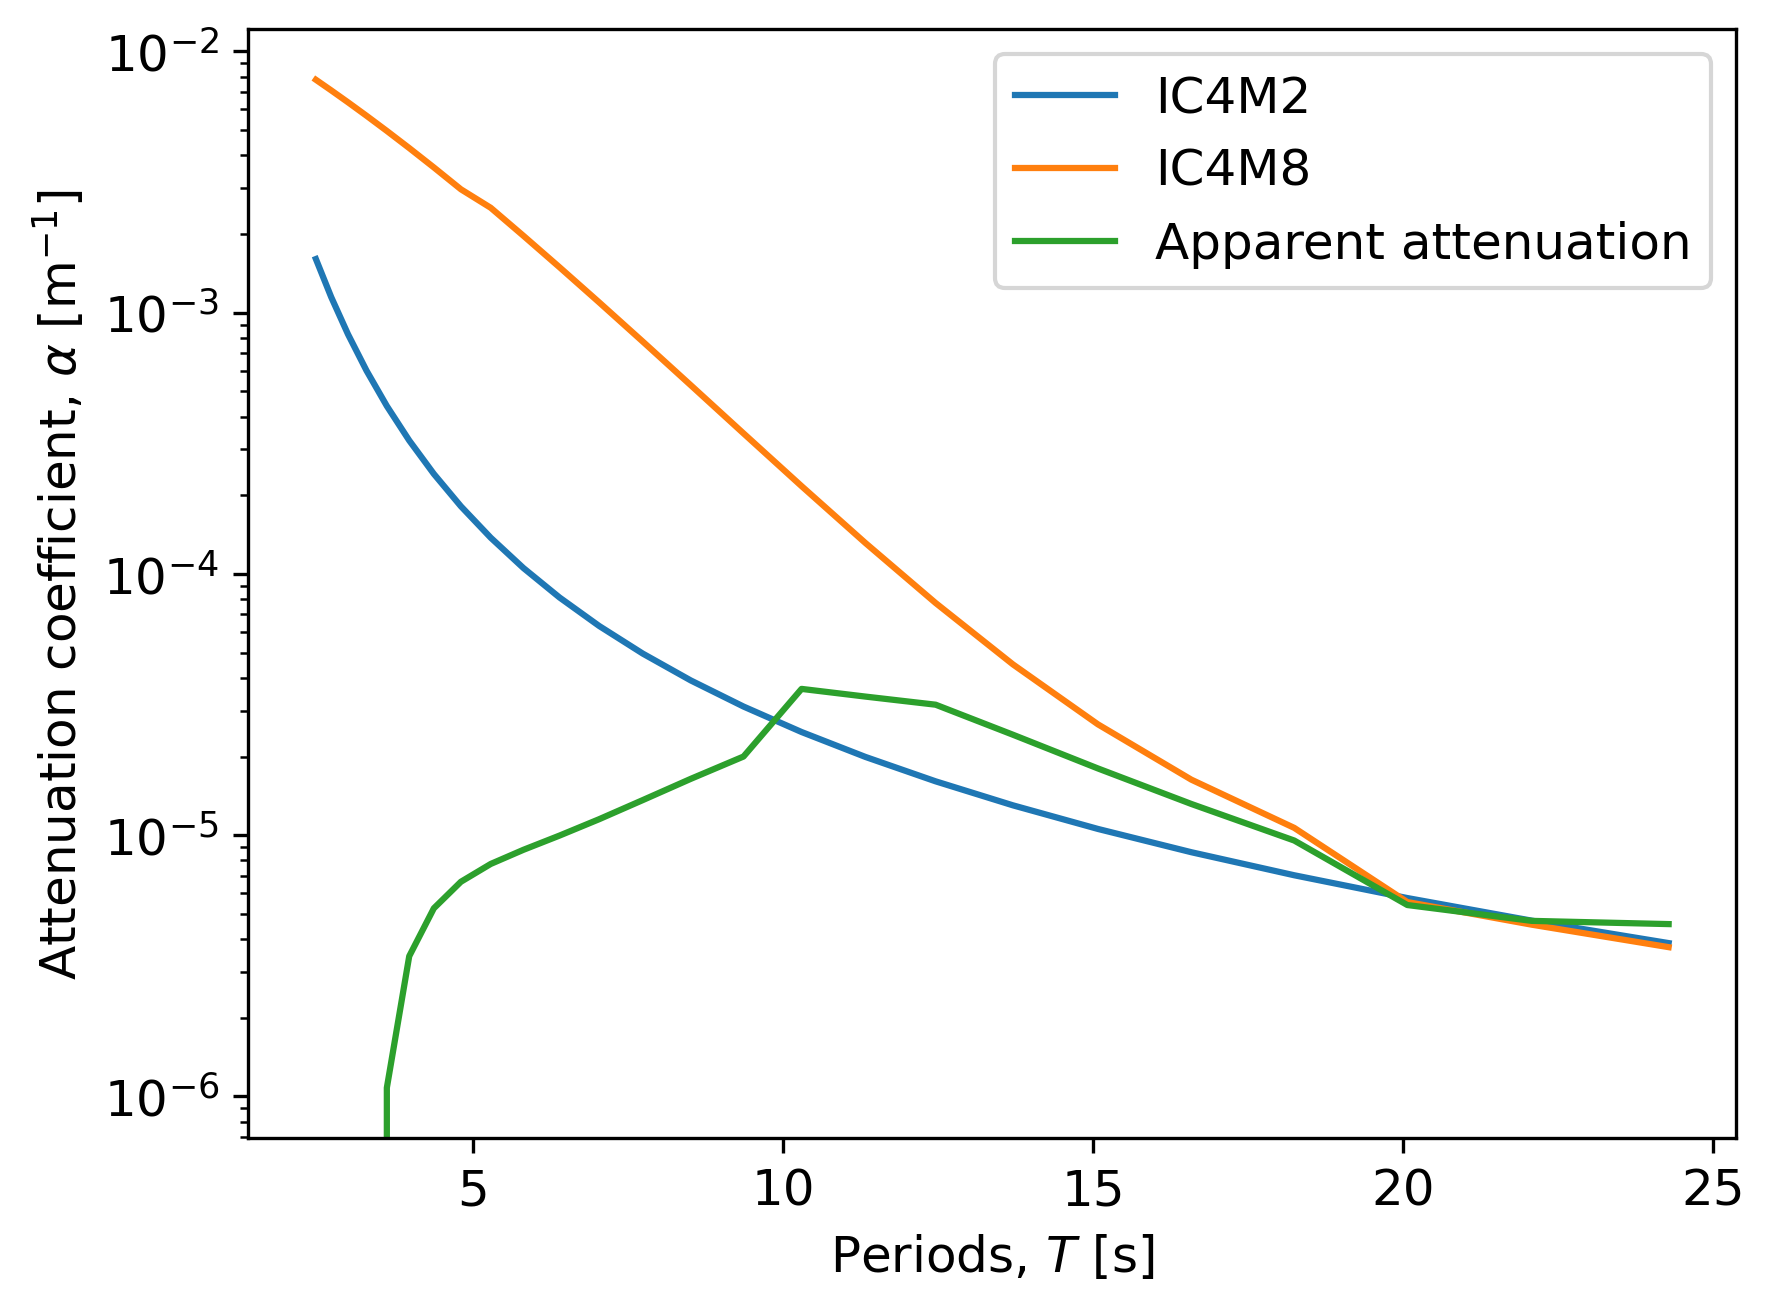

In [188]:
# Parameters from SPECTRUM_NML
frequencies, periods = get_ww3_freqs(nk=25)

Hs_init = ds_transect['HS'].max()
thickness = ds_transect['ICEH'].mean()
floeDiameter = ds_transect['ICEF'].mean()

α_mbk = mbk_2014_attenuation(periods)
α_meylan, _ = meylan_2021_attenuation(periods, thickness, floeDiameter)

plt.plot(periods, α_mbk, label='IC4M2')
plt.plot(periods, α_meylan, label='IC4M8')
plt.plot(periods, alpha, label='Apparent attenuation')
plt.legend()
plt.xlabel('Periods, $T$ [s]')
plt.ylabel('Attenuation coefficient, $\\alpha$ [m$^{-1}$]')
plt.yscale('log')

In [26]:
client.close()